# Lecture 1: Introduction to Neural Networks

In this lecture, we will use the famous MNIST data set (hand-written digits). We will use two different feed-forward NN
architectures, and we will compare the accuracies of the models. For the first model, we will construct the NN from scratch, explicitly defining the forward-pass and backpropagation (see theory notes). For the second one, we will use built-in functions in tensorflow to construct the neural network. The goal of this lecture is to familiarize ourselves with python and the functions used in Deep Learning. Also, we will comment on some fundamental aspects of neural network architecture, and their impact on the performance of the model.

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
#Load the MNIST dataset
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
data, target = mnist['data'], mnist['target']
data = data.reshape(-1,28,28).astype(np.uint8)
target = target.astype(int)

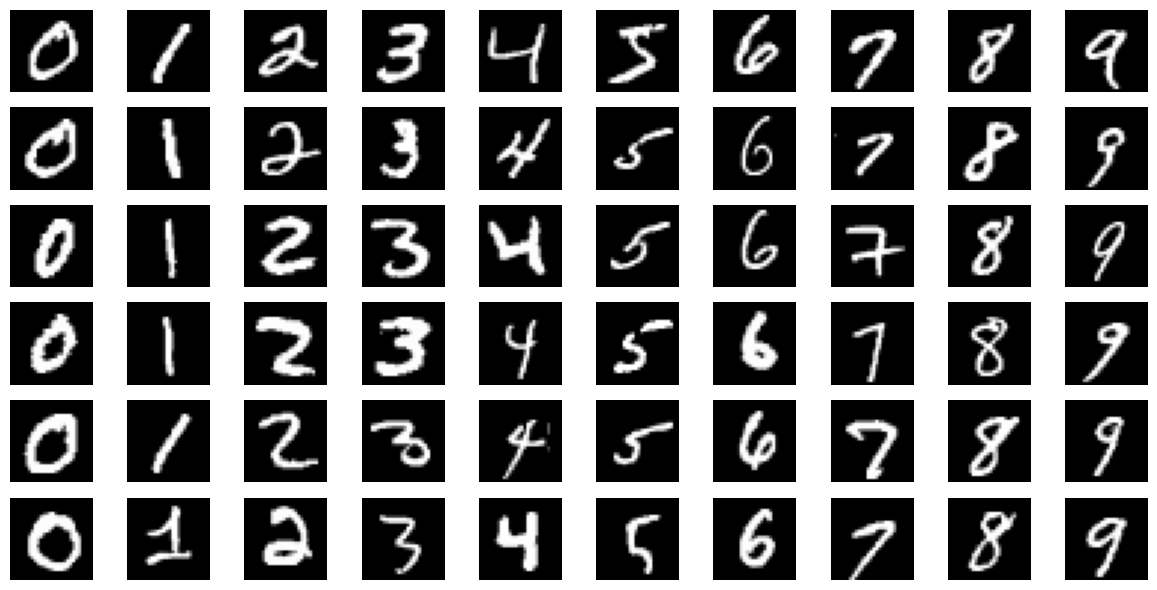

In [4]:
##This chunk is just for visualizing some of the data, so don't bother trying to understand every line of code

#Function to get unique styles of each digit

def get_unique_digits(images, labels, num_samples=6):
    unique_digits = {i: [] for i in range(10)}
    for img, lbl in zip(images, labels):
        if len(unique_digits[lbl]) < num_samples:
            unique_digits[lbl].append(img)
        if all(len(v) == num_samples for v in unique_digits.values()):
            break
    return unique_digits

# Get 6 unique styles for each digit
unique_digits = get_unique_digits(data, target, num_samples=6)

# Prepare rows of digits with varying styles
rows = [[unique_digits[digit][i] for digit in range(10)] for i in range(6)]

# Create and display a grid of digits
fig, axes = plt.subplots(6, 10, figsize=(12, 6))

for row_index, row in enumerate(rows):
    for col_index, digit_image in enumerate(row):
        ax = axes[row_index, col_index]
        ax.imshow(digit_image, cmap="gray")
        ax.axis("off")

plt.tight_layout()
plt.savefig("fig_1_5_MNIST_examples.png", dpi=500, format="png")
plt.show()

In [5]:
#Splitting and Normalizing data (very important for any ML task!)

import tensorflow as tf
from tqdm.auto import tqdm

#Split data into training and testing

(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

#Split training data into train and validation
np.random.seed(7)
idx_rnd = np.random.permutation(np.arange(x_train.shape[0]))
split = int(0.1 * x_train.shape[0])
idx_val, idx_train = idx_rnd[:split],idx_rnd[split:]
x_val, y_val = x_train[idx_val], y_train[idx_val]
x_train, y_train = x_train[idx_train], y_train[idx_train]

n_train, n_val, n_test = x_train.shape[0], x_val.shape[0], x_test.shape[0]

#Normalize the data
def normalize(x):
    return(x-np.mean(x,axis=1)[:,None]) / np.std(x,axis=1)[:,None]

X_train = normalize(x_train.reshape(n_train,-1))
X_val = normalize(x_val.reshape(n_val,-1))
X_test = normalize(x_test.reshape(n_test,-1))

#Scale the target values (we do this bc first we will use a NN with just one neuron in the last layer. The output will be
#a number between 0 and 1, and the decimal place will indicate the predicted digit, e.g. 0.19 ~ 0.2 -> 2)

Y_train, Y_val, Y_test = y_train/10.0, y_val / 10.0, y_test / 10.0


c:\Users\pablo\OneDrive\Documentos\Master\Machine Learning\DeepLearning-MQST\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 500/500 [02:21<00:00,  3.53it/s]


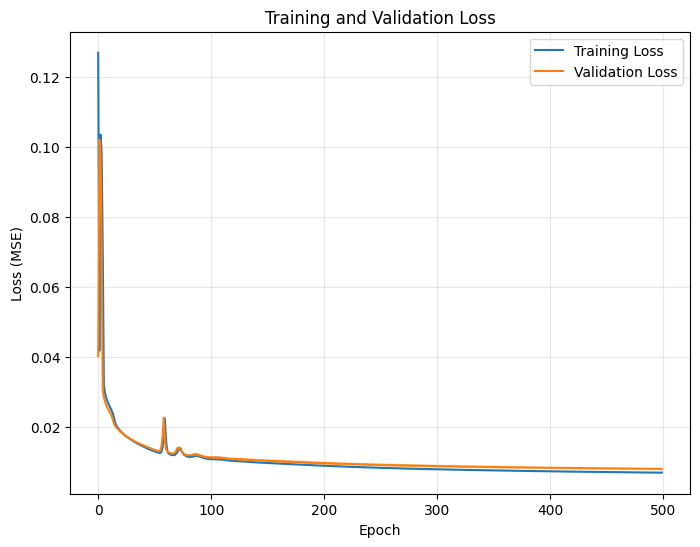

In [8]:
#Now we build a simple neural network, with forward and backpropagation to predict digits

#Activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

#Two-layer NN
def forward(x,w_1,b_1,w_2):
    h = x @ w_1 + b_1
    h_hat = sigmoid(h)
    g = h_hat @ w_2
    return sigmoid(g), g, h_hat, h

#Check the derivatives in the Theory Notes. Here, grad actually means partial deriv of the loss w.r.t some parameter
def backward(x,y,y_pred,w_2,h_hat):
    Q_2 = (y_pred - y[:,None])* y_pred * (1-y_pred)
    Q_1 = Q_2 @ w_2.T * h_hat * (1-h_hat)
    grad_w_1 = x.T @ Q_1
    grad_b_1 = np.sum(Q_1,axis=0)
    grad_w_2 = h_hat.T @ Q_2
    return grad_w_1, grad_b_1, grad_w_2

#Initialize weigths and biases
np.random.seed(0)
m,h,c = X_train.shape[1], 21, 1

#m is the number of input "features"
#h is the number of neurons in the hidden layer
#c is the number of neurons in the output layer

w_1_initial = 1*(np.random.rand(m,h) - 0.9)
w_2_initial = 1*(np.random.rand(h,c) - 0.9)
b_1_initial = 1*(np.random.rand(h) - 0.9)

w_1 = w_1_initial.copy()
w_2 = w_2_initial.copy()
b_1 = b_1_initial.copy()

eta = 50 #Learning rate (which need not to be necessarily small, although it often is)
n_epoch = 500 #Number of times that the parameters (weights & biases) will be 'updated', i.e. number of steps in GD

loss_train_vs_epoch = []
loss_val_vs_epoch = []

for epoch in tqdm(range(n_epoch)):

    #Compute loss
    Y_pred, _, h_hat, _ = forward(X_train,w_1,b_1,w_2)
    loss_train = 0.5*np.mean((Y_pred.squeeze()-Y_train)**2)
    loss_train_vs_epoch.append(loss_train)

    #Compute gradient and update parameters
    grad_w_1, grad_b_1, grad_w_2 = backward(X_train, Y_train, Y_pred, w_2, h_hat)
    w_1 -= eta / n_train * grad_w_1
    b_1 -= eta / n_train * grad_b_1
    w_2 -= eta / n_train * grad_w_2

    #Compute validation loss
    Y_pred, _, _, _ = forward(X_val,w_1,b_1,w_2)
    loss_val = 0.5 * np.mean((Y_pred.squeeze() - Y_val) ** 2)
    loss_val_vs_epoch.append(loss_val)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss_train_vs_epoch, label="Training Loss")
plt.plot(loss_val_vs_epoch, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Training and Validation Loss")
plt.show()

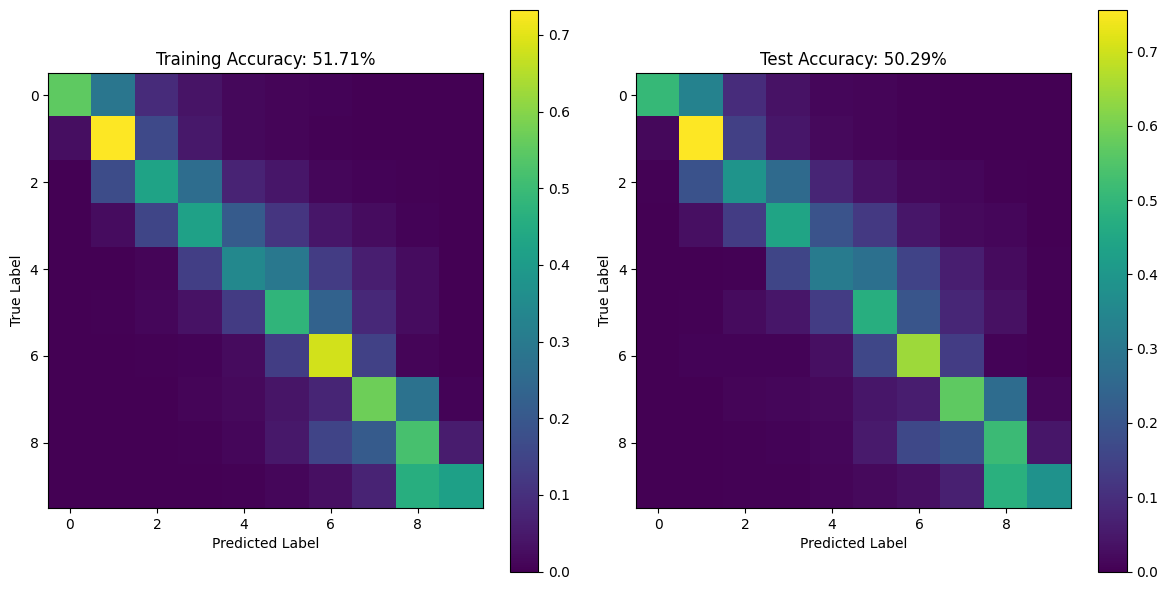

In [9]:
#To analyze the performance of the NN, we construct and plot the confusion matrix

def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)
        idx = idx[idx < len(labels)]
        counts = counts[:len(idx)]
        confusion_matrix[label, idx] = counts
    for i in range(confusion_matrix.shape[0]):
        confusion_matrix[i, :] /= np.sum(confusion_matrix[i, :])
    return confusion_matrix

# Predictions and accuracy
pred_train, _, _, _ = forward(X_train, w_1, b_1, w_2)
pred_train = np.around(10 * pred_train).astype(int).squeeze()
true_train = (10 * Y_train).astype(int)
conf_mat_train = get_confusion_matrix(pred_train, true_train)
accuracy_train = (pred_train == true_train).mean()

pred_test, _, _, _ = forward(X_test, w_1, b_1, w_2)
pred_test = np.around(10 * pred_test).astype(int).squeeze()
true_test = (10 * Y_test).astype(int)
conf_mat_test = get_confusion_matrix(pred_test, true_test)
accuracy_test = (pred_test == true_test).mean()

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(conf_mat_train, cmap='viridis')
ax[0].set_title(f'Training Accuracy: {accuracy_train:.2%}')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(conf_mat_test, cmap='viridis')
ax[1].set_title(f'Test Accuracy: {accuracy_test:.2%}')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
plt.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

Even though the NN we used was extremely simple, it already achieved a 50% accuracy, which is far better than randomly 
guessing the digit, which would have a success prob. of 10%. 

The question now is: can we do better? Yes!

In [11]:
#In this second part, we will change the architecture of the NN, and we will obtain far better results! Also, instead of
#constructing explicitly the NN, we will use some libraries that will do this for us.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Instead of predicting a single value between 0 and 1, where the first decimal indicates the predicted digit, we will
be using One-hot encoding. Each digit (or class in a general classification task) is represented by a vector that has
a 1 in a specific position, and 0's in the rest of positions. We can think of this as our model trying to predict a 
probability mass function (p.m.f), which ideally would assign probability close to 1 to a certain digit n, when the 
input digit is that same n.

In [14]:
# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten input to a 28^2 vector and rescale to zero mean and unit variance
X_train = X_train.reshape(-1, 28 * 28).astype('float32')
X_test = X_test.reshape(-1, 28 * 28).astype('float32')

# Normalize data
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split training set into train and validation (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
# Define the neural network model
model = Sequential([
    Dense(21, activation='sigmoid', input_shape=(28 * 28,)),  # Hidden layer with 21 neurons
    Dense(10, activation='softmax')  # Output layer with 10 nodes
])

eta = 1.0
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #See theory notes!

# Train the model with one batch (batch size = training set size)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=len(X_train),
                    verbose=2)

c:\Users\pablo\OneDrive\Documentos\Master\Machine Learning\DeepLearning-MQST\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
1/1 - 1s - 1s/step - accuracy: 0.0854 - loss: 2.5452 - val_accuracy: 0.2363 - val_loss: 2.1591
Epoch 2/500
1/1 - 0s - 250ms/step - accuracy: 0.2402 - loss: 2.1598 - val_accuracy: 0.4192 - val_loss: 1.9325
Epoch 3/500
1/1 - 0s - 226ms/step - accuracy: 0.4220 - loss: 1.9334 - val_accuracy: 0.5901 - val_loss: 1.6613
Epoch 4/500
1/1 - 0s - 224ms/step - accuracy: 0.5882 - loss: 1.6639 - val_accuracy: 0.6766 - val_loss: 1.5035
Epoch 5/500
1/1 - 0s - 225ms/step - accuracy: 0.6776 - loss: 1.5050 - val_accuracy: 0.6961 - val_loss: 1.4017
Epoch 6/500
1/1 - 0s - 231ms/step - accuracy: 0.6933 - loss: 1.4039 - val_accuracy: 0.7306 - val_loss: 1.3214
Epoch 7/500
1/1 - 0s - 226ms/step - accuracy: 0.7295 - loss: 1.3235 - val_accuracy: 0.7412 - val_loss: 1.2370
Epoch 8/500
1/1 - 0s - 220ms/step - accuracy: 0.7379 - loss: 1.2398 - val_accuracy: 0.7691 - val_loss: 1.1599
Epoch 9/500
1/1 - 0s - 224ms/step - accuracy: 0.7677 - loss: 1.1624 - val_accuracy: 0.7874 - val_loss: 1.0899
Epoch 10/500


In [16]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

# Extract loss and accuracy data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

# Predictions
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_val_true = np.argmax(y_val, axis=1)




1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


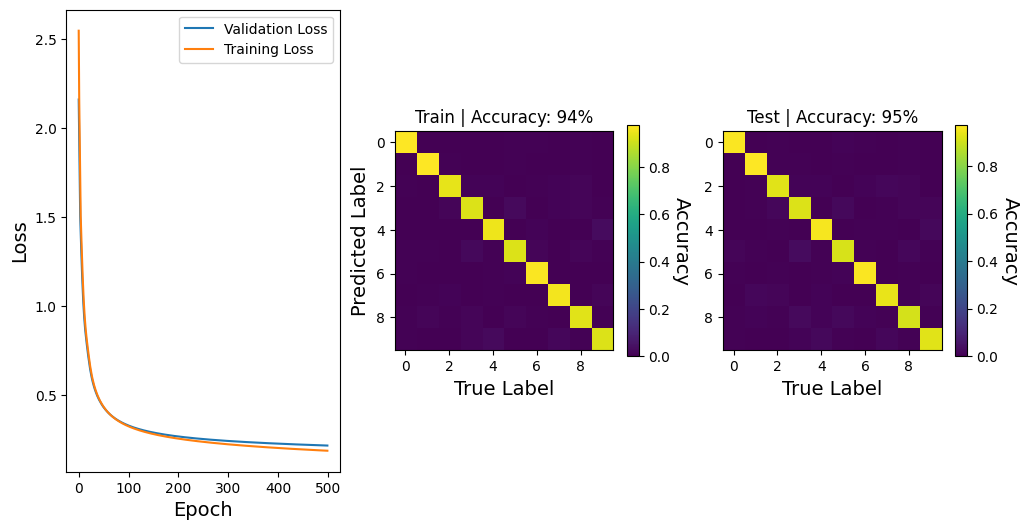

In [17]:
#We must redefine the confusion matrix
def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)

        idx_ = np.where(idx < 10)
        idx = idx[idx_]
        counts = counts[idx_]
        confusion_matrix[label, idx] = counts

    for i in range(0, confusion_matrix.shape[0]):
        all_data = np.sum(confusion_matrix[i, :])
        confusion_matrix[i, :] = confusion_matrix[i, :] / all_data
    return confusion_matrix

conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_test = get_confusion_matrix(y_val_pred, y_val_true)

accuracy_test = np.mean(np.diag(conf_mat_train)) * 100
accuracy_train = np.mean(np.diag(conf_mat_test)) * 100

# Plotting results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
FontSize = 14

ax[0].plot(validation_loss, label='Validation Loss')
ax[0].plot(training_loss, label='Training Loss')
ax[0].set_ylabel('Loss', fontsize=FontSize)
ax[0].set_xlabel('Epoch', fontsize=FontSize)
ax[0].legend()

im1 = ax[1].imshow(conf_mat_train, cmap="viridis")
im2 = ax[2].imshow(conf_mat_test, cmap="viridis")
ax[2].set_title(f"Test | Accuracy: {accuracy_test:.0f}%")
ax[1].set_title(f"Train | Accuracy: {accuracy_train:.0f}%")

ax[1].set_ylabel("Predicted Label", fontsize=FontSize)
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.5)
cbar1.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=0.5)
cbar2.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)

ax[1].set_xlabel("True Label", fontsize=FontSize)
ax[2].set_xlabel("True Label", fontsize=FontSize)

plt.savefig("./mnist_categorical_cross_entropy.png", dpi=500, format='png', bbox_inches='tight')
plt.show()

We see that the accuracy has improved a lot! And the only thing we have changed is the number of neurons in the output
layer!

The main takeaway from this lecture is the fact that using NN is all about the architecture we use. We have seen that the
smallest change in the architecture can take us from 50% accuracy to 95%, which is a drastic improvement. Thus, it is
worth it taking the time to figure out which architecture is best for a given task. In fact, there is a whole field of
research dedicated to studying NN architectures for specific problems! 